In [14]:
import os
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
)

# ------------------------------------------------------------------
# Reproducibility & device safety
# ------------------------------------------------------------------
SEED = 38
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if DEVICE.type == "cuda":
    torch.cuda.manual_seed_all(SEED)
print(f"Using device: {DEVICE}")

Using device: cuda


In [15]:
model_name = "DeepChem/ChemBERTa-77M-MTR"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=1,
    problem_type="regression" 
).to(DEVICE)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Read data
df = pd.read_csv('../data/QM9.csv')
df = df[['SMILES', 'U']]

train_df, test_df = train_test_split(
    df, test_size=0.20, random_state=SEED
)
train_df, val_df = train_test_split(
    train_df, test_size=0.20, random_state=SEED
)

print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 85686, Validation size: 21422, Test size: 26777


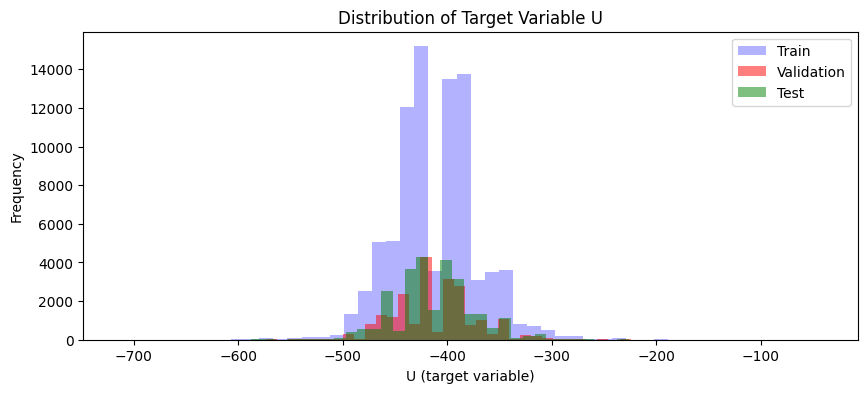

In [21]:
# Histogram of target variable of train, validation, and test sets on the same plot
plt.figure(figsize=(10, 4))
plt.hist(train_df['U'], bins=50, alpha=0.3, label='Train', color='blue')
plt.hist(val_df['U'], bins=50, alpha=0.5, label='Validation', color='red')
plt.hist(test_df['U'], bins=50, alpha=0.5, label='Test', color='green')
plt.xlabel('U (target variable)')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable U')
plt.legend()
plt.show()

In [4]:
# normalize target variable
scaler = StandardScaler()
train_df['U'] = scaler.fit_transform(train_df[['U']])
val_df['U'] = scaler.transform(val_df[['U']])   
test_df['U'] = scaler.transform(test_df[['U']])

In [ ]:
def tokenize_data(df):
    return tokenizer(
        df['SMILES'].tolist(),
        padding=True,
        truncation=True,
        max_length=256,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_df)
val_encodings = tokenize_data(val_df)
test_encodings = tokenize_data(test_df)

train_labels = torch.tensor(train_df['U'].values, dtype=torch.float32)
val_labels = torch.tensor(val_df['U'].values, dtype=torch.float32)
test_labels = torch.tensor(test_df['U'].values, dtype=torch.float32)

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], test_labels)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)

# Optimizer & Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_loader) * 4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
loss_fn = torch.nn.MSELoss()

# Training loop
for epoch in range(4):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids, attention_mask, labels = [b.to(DEVICE) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze()
        loss = loss_fn(preds, labels)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} training loss: {avg_loss:.4f}")

    model.eval()
    val_preds, val_targets = [], []
    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = [b.to(DEVICE) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = outputs.logits.squeeze()
            val_preds.extend(preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())
    val_preds_inv = scaler.inverse_transform(np.array(val_preds).reshape(-1, 1)).flatten()
    val_targets_inv = scaler.inverse_transform(np.array(val_targets).reshape(-1, 1)).flatten()
    val_mse = np.mean((val_preds_inv - val_targets_inv) ** 2)
    print(f"Epoch {epoch+1} validation MSE: {val_mse:.4f}")

model.eval()
test_preds, test_targets = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [b.to(DEVICE) for b in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze()
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())
        
test_preds_inv = scaler.inverse_transform(np.array(test_preds).reshape(-1, 1)).flatten()
test_targets_inv = scaler.inverse_transform(np.array(test_targets).reshape(-1, 1)).flatten()
test_mse = np.mean((test_preds_inv - test_targets_inv) ** 2)
print(f"Test MSE: {test_mse:.4f}")

Epoch 1: 100%|██████████| 1339/1339 [00:10<00:00, 121.84it/s]


Epoch 1 training loss: 0.1114
Epoch 1 validation MSE: 28.4760


Epoch 2: 100%|██████████| 1339/1339 [00:12<00:00, 109.65it/s]


Epoch 2 training loss: 0.0353
Epoch 2 validation MSE: 19.5810


Epoch 3: 100%|██████████| 1339/1339 [00:12<00:00, 109.94it/s]


Epoch 3 training loss: 0.0268
Epoch 3 validation MSE: 19.7788


Epoch 4: 100%|██████████| 1339/1339 [00:10<00:00, 133.23it/s]


Epoch 4 training loss: 0.0235
Epoch 4 validation MSE: 16.1111
Test MSE: 16.2092


In [9]:
results_df = pd.DataFrame({
    'SMILES': test_df['SMILES'],
    'Predicted_U': test_preds_inv,
    'True_U': test_targets_inv
})

results_df

,SMILES,Predicted_U,True_U
109094,CCC1=CC=CCCC1,-350.455902,-351.172943
126738,CCN1C=CC(OC)=N1,-420.528412,-419.217926
61920,CC(NCC#N)C1CN1,-398.751160,-399.288086
17598,CC(=O)C(=O)N1CC1,-400.258087,-399.802094
94339,OC1CCC11CC1C#C,-383.961517,-385.820740
...,...,...,...
118746,CC1(CCO)CC(O)C1,-423.637512,-425.399719
47039,O=C1CC2CCC2CO1,-424.646271,-423.056458
129113,N=C1CC2=C(ON=N2)O1,-471.401398,-468.822296
3528,CC1C2C3OC2C13,-314.663666,-308.415131


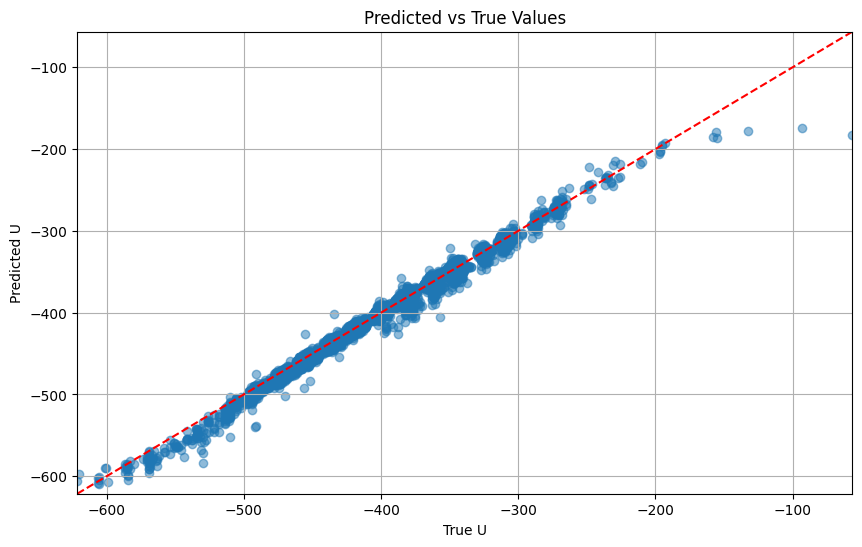

In [12]:
# Plot a scatter plot of predictions vs true values
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(test_targets_inv, test_preds_inv, alpha=0.5)
plt.plot([test_targets_inv.min(), test_targets_inv.max()], 
         [test_targets_inv.min(), test_targets_inv.max()], 
         color='red', linestyle='--')
plt.title('Predicted vs True Values')
plt.xlabel('True U')
plt.ylabel('Predicted U')
plt.xlim(test_targets_inv.min(), test_targets_inv.max())
plt.ylim(test_targets_inv.min(), test_targets_inv.max())
plt.grid()
plt.show()
